In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import tensorflow as tf

print("TensorFlow Version:", tf.__version__)
print("Using CUDA GPU:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.14.0
Using CUDA GPU: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:

print("TensorFlow Version:", tf.__version__)
print("Using CUDA GPU:", tf.test.is_built_with_cuda())
print("TensorRT Available:", tf.test.is_built_with_tensorrt())


TensorFlow Version: 2.14.0
Using CUDA GPU: True


AttributeError: module 'tensorflow._api.v2.test' has no attribute 'is_built_with_tensorrt'

In [ ]:
STFT = np.load('STFT.npy')
labels = np.load('LOS.npy')
STFT_signal= np.stack((abs(STFT), np.angle(STFT)), axis = 3)
STFT_signal.shape

In [ ]:
plt.pcolormesh(10 * np.log10(sp.fft.fftshift(STFT[3241,:,:], axes = 0)), shading='gouraud')
plt.colorbar()  # Add a colorbar for reference

# Set axis labels and title
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Spectogram')

# Show the plot
plt.show()


In [4]:
#PRS = np.load('PRS.npy')
#FE = np.load('FE.npy')
labels = np.load('LOS.npy')
#cor = np.load('cor.npy')
RX = np.load('RX_time.npy')
RX = np.transpose(np.reshape(np.stack((np.abs(RX), np.angle(RX)), axis = -2), (RX.shape[0], RX.shape[2], -1)), [0,2,1])
print(f'RX shape = {RX.shape}')#\ncorrelation shape = {cor.shape}\nstatistical feature shape = {FE.shape},\nLOS = {np.unique(labels, return_counts=True)}')
#print(f'statistical feature shape = {FE.shape},\nLOS/NLOS labels = {np.unique(labels, return_counts=True)}')

RX shape = (7102, 10, 2048)


In [5]:
from keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [6]:
 tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/usr/lib/llvm-16/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [7]:
import tensorflow as tf

print(f'\nTensorflow version = {tf.__version__}\n')
print(f'\n{tf.config.list_physical_devices("GPU")}\n')


Tensorflow version = 2.14.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [8]:
X_train, X_test, y_train, y_test = train_test_split(RX, labels, test_size=0.2, random_state=42, stratify=labels)

In [9]:
encoder = OneHotEncoder(sparse_output = False)
binary_labels = y_train.reshape(-1, 1)
y_onehot_encoded = encoder.fit_transform(binary_labels)

In [161]:
# Create a Sequential model
model = tf.keras.Sequential(name = 'LSTM-Conv1D')

# Input layer for (2048, 5, 2)
model.add(layers.InputLayer(input_shape=(10,2048)))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.L2(1e-5)))
model.add(layers.Dropout(rate = 0.8)) 
model.add(layers.Conv1D(32, kernel_size=3, strides=2, activation='relu', kernel_regularizer=regularizers.L2(1e-3), padding='same'))
model.add(layers.MaxPooling1D(pool_size=2))



model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.L2(1e-1)))
model.add(layers.Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy',
                                                                     tf.keras.metrics.F1Score(average = 'weighted', threshold = None, name = 'f1'), 
                                                                     tf.keras.metrics.AUC(num_thresholds=100, name = 'auc', from_logits=True),
                                                                         ])

# Print the model summary
model.summary()


Model: "LSTM-Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_49 (Ba  (None, 10, 2048)          8192      
 tchNormalization)                                               
                                                                 
 lstm_50 (LSTM)              (None, 10, 64)            540928    
                                                                 
 dropout_33 (Dropout)        (None, 10, 64)            0         
                                                                 
 conv1d_60 (Conv1D)          (None, 5, 32)             6176      
                                                                 
 max_pooling1d_52 (MaxPooli  (None, 2, 32)             0         
 ng1D)                                                           
                                                                 
 flatten_37 (Flatten)        (None, 64)                

In [162]:
from sklearn.utils.class_weight import compute_class_weight
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
validation_split = 0.2
history = model.fit(X_train, y_onehot_encoded, 
          class_weight=class_weight_dict, 
          #validation_data=(X_val, y_val), 
          validation_split=validation_split,
          callbacks=[early_stopping],
          epochs=50, batch_size=128, shuffle=True)

Epoch 1/50
36/36 [==============================] - 5s 65ms/step - loss: 5.3339 - accuracy: 0.4734 - f1: 0.5944 - auc: 0.4697 - val_loss: 4.2729 - val_accuracy: 0.5084 - val_f1: 0.6333 - val_auc: 0.5016
Epoch 2/50
36/36 [==============================] - 0s 13ms/step - loss: 3.5416 - accuracy: 0.5438 - f1: 0.6545 - auc: 0.5211 - val_loss: 2.8866 - val_accuracy: 0.5497 - val_f1: 0.6685 - val_auc: 0.5411
Epoch 3/50
36/36 [==============================] - 0s 14ms/step - loss: 2.3992 - accuracy: 0.5519 - f1: 0.6607 - auc: 0.5475 - val_loss: 1.9952 - val_accuracy: 0.6790 - val_f1: 0.7674 - val_auc: 0.6735
Epoch 4/50
36/36 [==============================] - 1s 14ms/step - loss: 1.6327 - accuracy: 0.7401 - f1: 0.8066 - auc: 0.7945 - val_loss: 1.2769 - val_accuracy: 0.9015 - val_f1: 0.8982 - val_auc: 0.9310
Epoch 5/50
36/36 [==============================] - 0s 14ms/step - loss: 1.0179 - accuracy: 0.8691 - f1: 0.8967 - auc: 0.9382 - val_loss: 0.8014 - val_accuracy: 0.9279 - val_f1: 0.9118 - v

dict_keys(['loss', 'accuracy', 'f1', 'auc', 'val_loss', 'val_accuracy', 'val_f1', 'val_auc'])


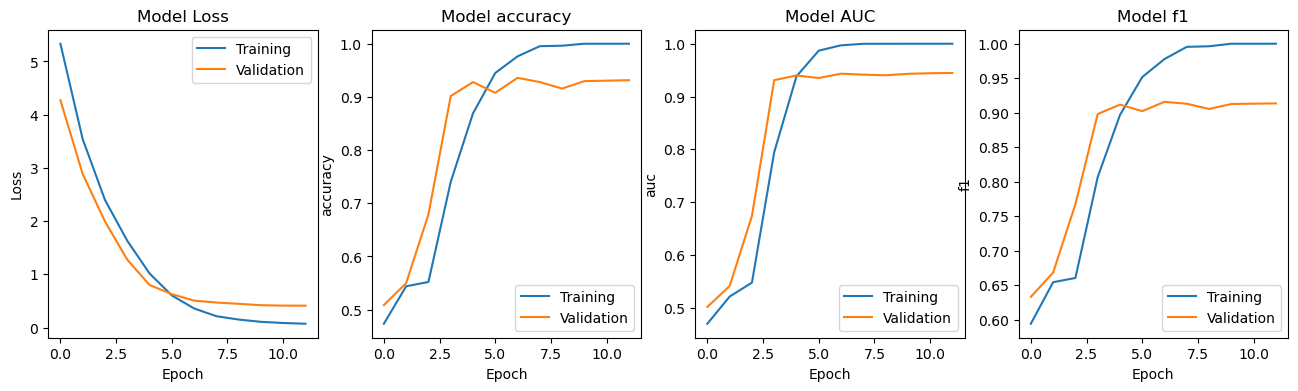

In [163]:
print(history.history.keys())


# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))

# Plot training & validation loss values on the first subplot (ax1)
ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

ax3.plot(history.history['auc'], label='Training')
ax3.plot(history.history['val_auc'], label='Validation')
ax3.set_title('Model AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('auc')
ax3.legend()

ax4.plot(history.history['f1'], label='Training')
ax4.plot(history.history['val_f1'], label='Validation')
ax4.set_title('Model f1')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('f1')
ax4.legend()
plt.show()



45/45 [==============================] - 1s 3ms/step


<Axes: >

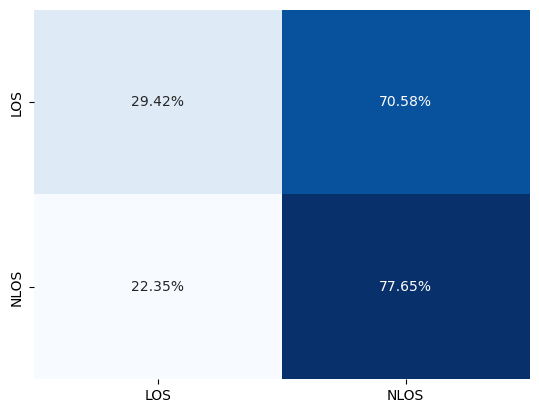

In [164]:
class_names = ['LOS', 'NLOS']
y_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1], drop_intermediate = True)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
#plt.plot(fpr,tpr)
y_pred = (y_proba[:, 1] > optimal_threshold).astype(int)  # Assuming binary classification
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names)


In [12]:
!nvidia-smi

Tue Nov  7 19:34:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
| 53%   50C    P2             139W / 390W |  22778MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--